In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply
import cv2
import numpy as np
from pathlib import Path

# Run 1 InceptionV3

## Load The Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'aptos2019' dataset.
Path to dataset files: /kaggle/input/aptos2019


In [3]:
os.listdir(path)

['val_images',
 'train_images',
 'valid.csv',
 'test.csv',
 'train_1.csv',
 'test_images']

In [4]:
unbalanced_data_path = path+'/train_images/train_images'

In [5]:
y_true = pd.read_csv(path+'/train_1.csv')
y_true['id_code'] = y_true['id_code'].str.replace('.png', '', regex=False) # Ensure id_code does NOT end with .png

In [6]:
y_true['diagnosis']=y_true['diagnosis'].astype(str)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


## Image Prepro


In [ ]:
IM_SIZE=224

In [ ]:
!rm -rf percent_train

In [ ]:
def create_augmentation_layer():
    """Augmentation for balancing: flips, rotation, crop, zoom"""
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.08, fill_mode="constant"),  # ~15 degrees
            tf.keras.layers.RandomZoom(0.1),
        ]
    )

In [ ]:
def augment_and_save_balanced_dataset(
    df, img_dir, output_dir, target_percentages=None, target_size=(IM_SIZE, IM_SIZE)
):
    """
    Augment classes based on percentage multipliers and save to disk

    Args:
        df: DataFrame with 'id_code' and 'diagnosis' columns
        img_dir: Source images directory
        output_dir: Where to save augmented dataset
        target_percentages: dict {class_id: multiplier} e.g. {0: 1.0, 1: 2.0, 3: 3.0}
                           1.0 = keep current, 2.0 = double, etc.
        target_size: Image resize dimensions

    Returns:
        new_df: DataFrame with all images (original + augmented)
    """
    from collections import Counter

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    class_counts = Counter(df["diagnosis"].values)
    print("Original distribution:", dict(class_counts))

    augmentation = create_augmentation_layer()
    new_data = []

    for class_id in sorted(class_counts.keys()):
        class_df = df[df["diagnosis"] == class_id]
        current_count = len(class_df)

        # Calculate target based on percentage
        multiplier = target_percentages.get(int(class_id), 1.0) if target_percentages else 1.0
        target_count = int(current_count * multiplier)
        needed = max(0, target_count - current_count)

        # Add all original images to metadata
        for _, row in class_df.iterrows():
            new_data.append({
                "id_code": row["id_code"], # row['id_code'] is without .png here
                "diagnosis": class_id,
                "is_augmented": False
            })

        # Generate augmented images
        if needed > 0:
            print(f"Class {class_id}: Augmenting {current_count} → {target_count} ({multiplier}x, +{needed} images)")

            for i in range(needed):
                # Sample random image from class
                row = class_df.sample(1).iloc[0]

                # Load with TF, adding .png extension
                img_path = os.path.join(img_dir, f"{row['id_code']}.png")
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, target_size)
                img = img / 255.0
                img = tf.expand_dims(img, 0)

                # Apply augmentation
                aug_img = augmentation(img, training=True)[0]

                # Save augmented image, new_id is created without .png extension
                new_id = f"{row['id_code']}_aug_{i}"
                save_path = str(output_dir / f"{new_id}.png") # Save with .png extension
                tf.keras.utils.save_img(save_path, aug_img)

                new_data.append({
                    "id_code": new_id, # Store without .png
                    "diagnosis": class_id,
                    "is_augmented": True
                })
        else:
            print(f"Class {class_id}: No augmentation needed (multiplier={multiplier}x)")

    # Save new CSV
    new_df = pd.DataFrame(new_data)
    new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)
    new_df.to_csv(output_dir / "labels.csv", index=False)

    print(f"\nTotal dataset: {len(new_df)} images")
    print(f"Augmented: {new_df['is_augmented'].sum()} images")
    print("Final distribution:", dict(Counter(new_df["diagnosis"].values)))

    return new_df

# Usage
target_percentages = {
    0: 1.0,   # No DR - keep as is
    1: 2.0,   # Mild - double
    2: 1.0,   # Moderate - keep as is
    3: 4.0,   # Severe - triple
    4: 4.0,   # Proliferative - 2.5x
}

balanced_df = augment_and_save_balanced_dataset(
    y_true,
   unbalanced_data_path,
    "percent_train",
    target_percentages=target_percentages
)

Original distribution: {'2': 808, '1': 300, '4': 234, '0': 1434, '3': 154}
Class 0: No augmentation needed (multiplier=1.0x)
Class 1: Augmenting 300 → 600 (2.0x, +300 images)
Class 2: No augmentation needed (multiplier=1.0x)
Class 3: Augmenting 154 → 616 (4.0x, +462 images)
Class 4: Augmenting 234 → 936 (4.0x, +702 images)

Total dataset: 4394 images
Augmented: 1464 images
Final distribution: {'3': 616, '2': 808, '1': 600, '0': 1434, '4': 936}


In [ ]:
def get_combined_paths(balanced_df, original_dir, augmented_dir):
    paths = []
    labels = []

    # Get absolute path for the augmented directory
    abs_augmented_dir = Path(augmented_dir).resolve()

    for _, row in balanced_df.iterrows():
        # balanced_df['id_code'] contains filenames WITHOUT .png extension
        if row['is_augmented']:
            # Augmented files were saved as {id_code}_aug_X.png
            path = abs_augmented_dir / f"{row['id_code']}.png"
        else:
            # Original files are {id_code}.png
            path = Path(original_dir) / f"{row['id_code']}.png"
        paths.append(str(path)) # Ensure it's a string
        labels.append(row['diagnosis'])

    return paths, labels

# Load balanced dataset

# balanced_df = pd.read_csv(f"{balanced_output_dir}/labels.csv")
# paths, labels = get_combined_paths(balanced_df, train_dir, f"{balanced_output_dir}")

percentage_train_set= "percent_train"
balanced_df = pd.read_csv(f"{percentage_train_set}/labels.csv")
paths, labels = get_combined_paths(balanced_df, unbalanced_data_path, f"{percentage_train_set}")

In [ ]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(IM_SIZE,IM_SIZE))
  image=image/255.0
  return image

In [ ]:
val_df=pd.read_csv(path+'/test.csv')
val_df['diagnosis']=val_df['diagnosis'].astype(str)
val_df['id_code']=val_df['id_code'].str.replace('.png', '', regex=False) # Ensure id_code does NOT end with .png
test_images=path+'/test_images/test_images/' # Corrected path for nested test images

In [ ]:
val_df

,id_code,diagnosis
0,e4dcca36ceb4,0
1,e4e343eaae2a,2
2,e4f12411fd85,4
3,e50b0174690d,0
4,e5197d77ec68,0
...,...,...
361,ffa47f6a7bf4,2
362,ffc04fed30e6,0
363,ffcf7b45f213,2
364,ffd97f8cd5aa,0


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=image_resize)

val_gen=ImageDataGenerator(preprocessing_function=image_resize)

train_df = pd.DataFrame({'id_code': paths, 'diagnosis': labels})
train_df['diagnosis'] = train_df['diagnosis'].astype(str)

train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = None, # x_col now contains full paths
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=32,
                                                    class_mode='categorical')

# For validation data, create full paths in a new column
val_df['full_path'] = val_df['id_code'].apply(lambda x: os.path.join(test_images, f"{x}.png"))
val_df['diagnosis'] = val_df['diagnosis'].astype(str)

val_gen = train_datagen.flow_from_dataframe(val_df,
                                                  x_col='full_path', # Use the full path
                                                  y_col='diagnosis',
                                                  directory = None, # No directory needed, paths are full
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 4394 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


## Add Weights

In [ ]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'].values)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}


print(class_weight_dict)

{'0': np.float64(0.6128312412831242), '1': np.float64(1.4646666666666666), '2': np.float64(1.0876237623762377), '3': np.float64(1.4266233766233767), '4': np.float64(0.9388888888888889)}


## Load InceptionV3 Model

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
print("Pre-trained InceptionV3 model loaded successfully.")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pre-trained InceptionV3 model loaded successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])


In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)

In [ ]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='inV3best_with_weights.keras',monitor='accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,restore_best_weights=True,mode='max')

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,592,869 (86.18 MB)

 Trainable params: 22,558,437 (86.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it])

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.8573 - loss: 0.3962 - val_accuracy: 0.7869 - val_loss: 0.7315
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.9332 - loss: 0.1905 - val_accuracy: 0.8142 - val_loss: 0.7645
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 461s 3s/step - accuracy: 0.9564 - loss: 0.1262 - val_accuracy: 0.8005 - val_loss: 0.7928
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.9764 - loss: 0.0727 - val_accuracy: 0.7896 - val_loss: 0.8688
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.9689 - loss: 0.0922 - val_accuracy: 0.7978 - val_loss: 0.8639
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.9719 - loss: 0.0814 - val_accuracy: 0.7978 - val_loss: 0.8701


## Model Evaluation

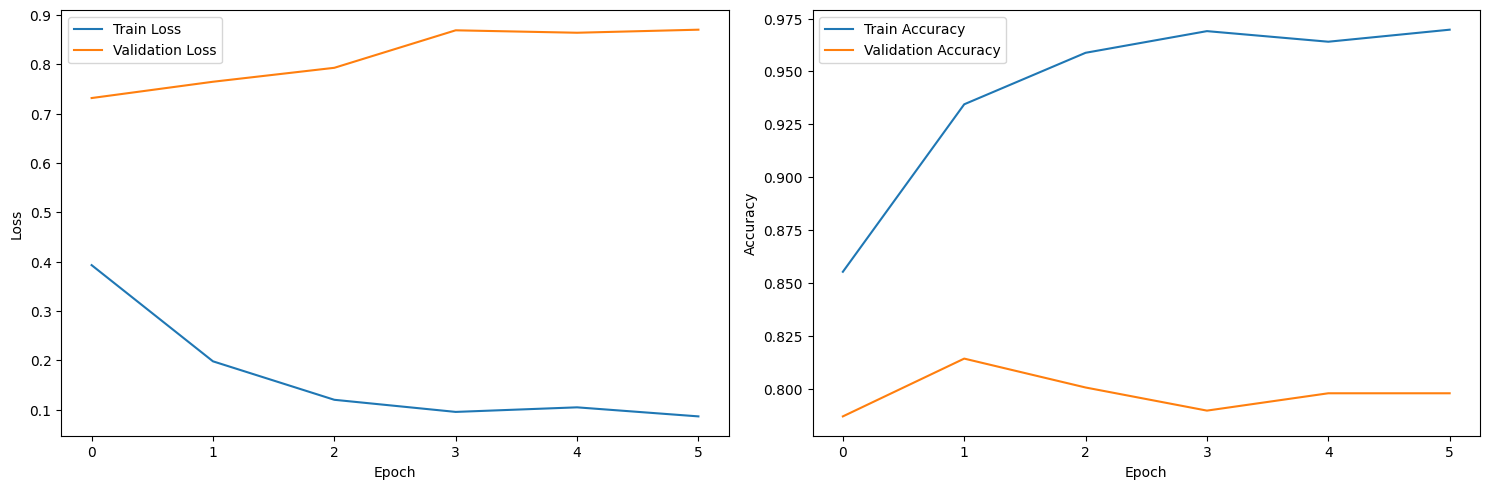

In [ ]:
ig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history.history['loss'],label='Train Loss')
axes[0].plot(history.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'],label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

In [ ]:
predictions=model.predict(val_gen)
predictions=np.argmax(predictions,axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step


<Axes: >

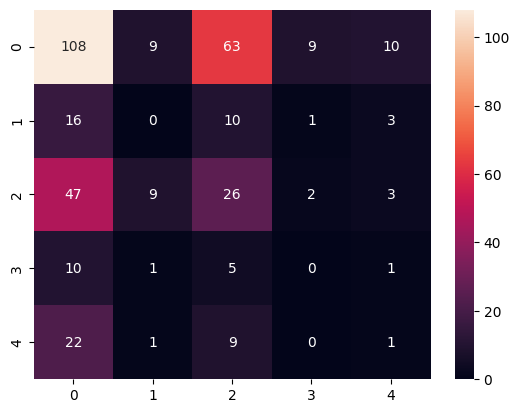

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(val_gen.classes,predictions),annot=True,fmt='d')

In [ ]:
print(classification_report(val_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.53      0.54      0.54       199
           1       0.00      0.00      0.00        30
           2       0.23      0.30      0.26        87
           3       0.00      0.00      0.00        17
           4       0.06      0.03      0.04        33

    accuracy                           0.37       366
   macro avg       0.16      0.17      0.17       366
weighted avg       0.35      0.37      0.36       366



In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

Sample image shape: (224, 224, 3)
Sample image processed shape for model input: (1, 224, 224, 3)
Sample label: [1. 0. 0. 0. 0.]


In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Raw attention map shape: (5, 5)
Resized attention map shape: (224, 224)
Model prediction for sample image: [[1.0000000e+00 4.5466933e-08 1.0330388e-08 1.4612277e-10 9.8035406e-11]]


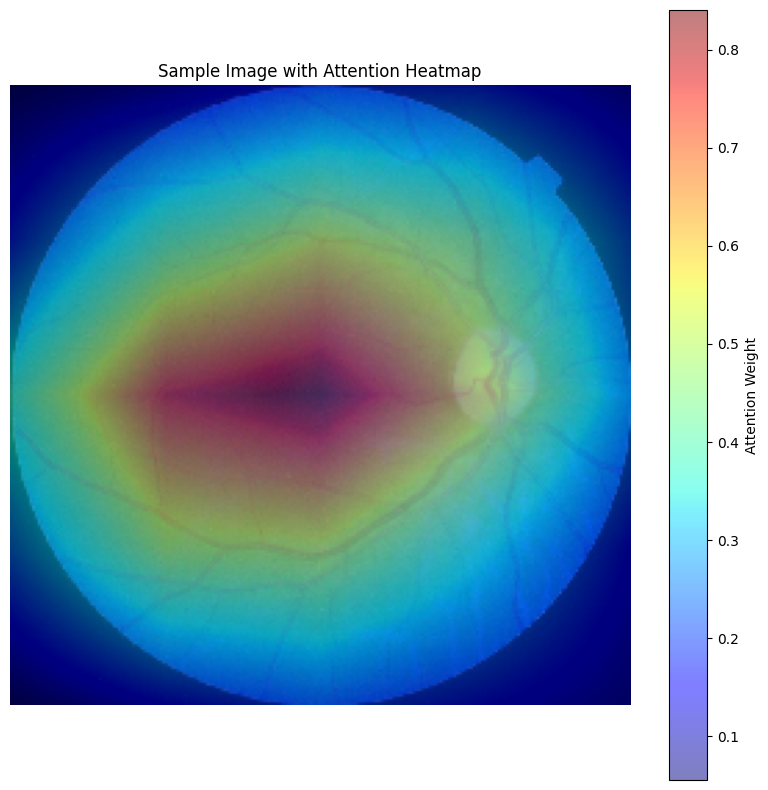

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.5)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

# Retrain InV3 with IM_size=512


## Augmentation

In [ ]:
import cv2
import numpy as np

def apply_clahe(image):

    if image.dtype != np.uint8:

        if image.max() <= 1.0 and image.min() >= 0.0:
            image = (image * 255).astype(np.uint8)
        else:

            image = image.astype(np.uint8)


    if len(image.shape) == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        l_channel, a_channel, b_channel = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)

        limg = cv2.merge((cl, a_channel, b_channel))

        enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    elif len(image.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or 3-channel color.")

    return enhanced_image

In [ ]:
IM_SIZE=512

In [ ]:
def create_augmentation_layer():
    """Augmentation for balancing: flips, rotation, crop, zoom"""
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.8, fill_mode="constant"),  # ~15 degrees
            tf.keras.layers.RandomZoom(0.3),
        ]
    )

In [ ]:
def augment_and_save_balanced_dataset(
    df, img_dir, output_dir, target_percentages=None, target_size=(IM_SIZE, IM_SIZE)
):
    """
    Augment classes based on percentage multipliers and save to disk

    Args:
        df: DataFrame with 'id_code' and 'diagnosis' columns
        img_dir: Source images directory
        output_dir: Where to save augmented dataset
        target_percentages: dict {class_id: multiplier} e.g. {0: 1.0, 1: 2.0, 3: 3.0}
                           1.0 = keep current, 2.0 = double, etc.
        target_size: Image resize dimensions

    Returns:
        new_df: DataFrame with all images (original + augmented)
    """
    from collections import Counter

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    class_counts = Counter(df["diagnosis"].values)
    print("Original distribution:", dict(class_counts))

    augmentation = create_augmentation_layer()
    new_data = []

    for class_id in sorted(class_counts.keys()):
        class_df = df[df["diagnosis"] == class_id]
        current_count = len(class_df)

        # Calculate target based on percentage
        multiplier = target_percentages.get(int(class_id), 1.0) if target_percentages else 1.0
        target_count = int(current_count * multiplier)
        needed = max(0, target_count - current_count)

        # Add all original images to metadata
        for _, row in class_df.iterrows():
            new_data.append({
                "id_code": row["id_code"], # row['id_code'] is without .png here
                "diagnosis": class_id,
                "is_augmented": False
            })

        # Generate augmented images
        if needed > 0:
            print(f"Class {class_id}: Augmenting {current_count} → {target_count} ({multiplier}x, +{needed} images)")

            for i in range(needed):
                # Sample random image from class
                row = class_df.sample(1).iloc[0]

                # Load with TF, adding .png extension
                img_path = os.path.join(img_dir, f"{row['id_code']}.png")
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, target_size)
                img = img / 255.0
                img = tf.expand_dims(img, 0)

                # Apply augmentation
                aug_img = augmentation(img, training=True)[0]

                # Save augmented image, new_id is created without .png extension
                new_id = f"{row['id_code']}_aug_{i}"
                save_path = str(output_dir / f"{new_id}.png") # Save with .png extension
                tf.keras.utils.save_img(save_path, aug_img)

                new_data.append({
                    "id_code": new_id, # Store without .png
                    "diagnosis": class_id,
                    "is_augmented": True
                })
        else:
            print(f"Class {class_id}: No augmentation needed (multiplier={multiplier}x)")

    # Save new CSV
    new_df = pd.DataFrame(new_data)
    new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)
    new_df.to_csv(output_dir / "labels.csv", index=False)

    print(f"\nTotal dataset: {len(new_df)} images")
    print(f"Augmented: {new_df['is_augmented'].sum()} images")
    print("Final distribution:", dict(Counter(new_df["diagnosis"].values)))

    return new_df

# Usage
target_percentages = {
    0: 1.0,   # No DR - keep as is
    1: 2.0,   # Mild - double
    2: 1.0,   # Moderate - keep as is
    3: 4.0,   # Severe - triple
    4: 4.0,   # Proliferative - 2.5x
}

balanced_df = augment_and_save_balanced_dataset(
    y_true,
   unbalanced_data_path,
    "percent_train",
    target_percentages=target_percentages
)

Original distribution: {'2': 808, '1': 300, '4': 234, '0': 1434, '3': 154}
Class 0: No augmentation needed (multiplier=1.0x)
Class 1: Augmenting 300 → 600 (2.0x, +300 images)
Class 2: No augmentation needed (multiplier=1.0x)
Class 3: Augmenting 154 → 616 (4.0x, +462 images)
Class 4: Augmenting 234 → 936 (4.0x, +702 images)

Total dataset: 4394 images
Augmented: 1464 images
Final distribution: {'3': 616, '2': 808, '1': 600, '0': 1434, '4': 936}


In [ ]:
def get_combined_paths(balanced_df, original_dir, augmented_dir):
    paths = []
    labels = []


    abs_augmented_dir = Path(augmented_dir).resolve()

    for _, row in balanced_df.iterrows():

        if row['is_augmented']:

            path = abs_augmented_dir / f"{row['id_code']}.png"
        else:

            path = Path(original_dir) / f"{row['id_code']}.png"
        paths.append(str(path))
        labels.append(row['diagnosis'])

    return paths, labels

percentage_train_set= "percent_train"
balanced_df = pd.read_csv(f"{percentage_train_set}/labels.csv")
paths, labels = get_combined_paths(balanced_df, unbalanced_data_path, f"{percentage_train_set}")

In [ ]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(IM_SIZE,IM_SIZE))
  image=apply_clahe(image)
  image=image/255.0
  return image

In [ ]:
val_df=pd.read_csv(path+'/test.csv')
val_df['diagnosis']=val_df['diagnosis'].astype(str)
val_df['id_code']=val_df['id_code'].str.replace('.png', '', regex=False)
test_images=path+'/test_images/test_images/'

## Data Sample

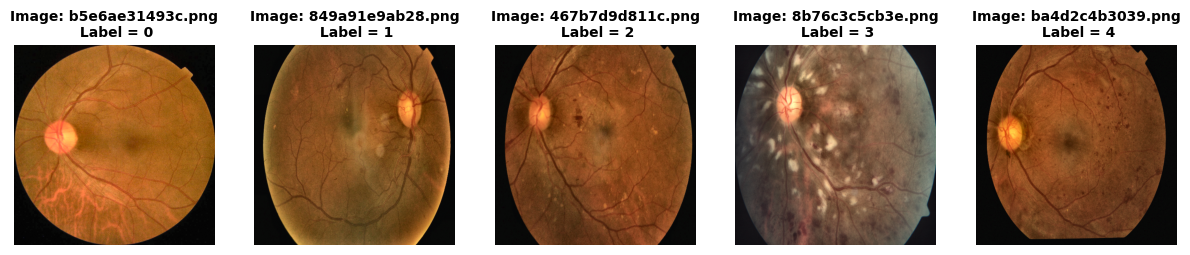

In [ ]:
train_df = pd.read_csv(path+'/train_1.csv')
train_df['id_code'] = train_df['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)


fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = image_resize(cv2.imread(f"{unbalanced_data_path}/{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## Make Train-Test Dataset

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=image_resize)

val_gen=ImageDataGenerator(preprocessing_function=image_resize)

train_df = pd.DataFrame({'id_code': paths, 'diagnosis': labels})
train_df['diagnosis'] = train_df['diagnosis'].astype(str)

train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = None,
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=32,
                                                    class_mode='categorical')


val_df['full_path'] = val_df['id_code'].apply(lambda x: os.path.join(test_images, f"{x}.png"))
val_df['diagnosis'] = val_df['diagnosis'].astype(str)

val_gen = train_datagen.flow_from_dataframe(val_df,
                                                  x_col='full_path',
                                                  y_col='diagnosis',
                                                  directory = None,
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=32,
                                                  class_mode='categorical')

Found 4394 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


In [ ]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'].values)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}


print(class_weight_dict)

{'0': np.float64(0.6128312412831242), '1': np.float64(1.4646666666666666), '2': np.float64(1.0876237623762377), '3': np.float64(1.4266233766233767), '4': np.float64(0.9388888888888889)}


## Load The New Model

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
print("Pre-trained InceptionV3 model loaded successfully.")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pre-trained InceptionV3 model loaded successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)

In [ ]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='inV3best_with_weights.keras',monitor='accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,restore_best_weights=True,mode='max')

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

##Train The New Model

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.5310 - loss: 1.2858 - val_accuracy: 0.5410 - val_loss: 1.1564
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.6876 - loss: 0.7915 - val_accuracy: 0.5574 - val_loss: 1.1016
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - accuracy: 0.8193 - loss: 0.5457 - val_accuracy: 0.4290 - val_loss: 1.3785
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - accuracy: 0.8475 - loss: 0.4372 - val_accuracy: 0.5984 - val_loss: 1.0176
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.9030 - loss: 0.3117 - val_accuracy: 0.7486 - val_loss: 0.6639
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - accuracy: 0.9442 - loss: 0.2096 - val_accuracy: 0.8087 - val_loss: 0.5245
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 512s 4s/step - accuracy: 0.9678 - loss: 0.1339 - val_accuracy: 0.8306 - val_loss: 0.5296
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 504s 4s/step - accuracy: 0.9786 - loss: 0.0931 - val_accu

## Evaluation

In [ ]:
model.evaluate(val_gen)

12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8421 - loss: 0.5850


[0.5403921604156494, 0.8387978076934814]

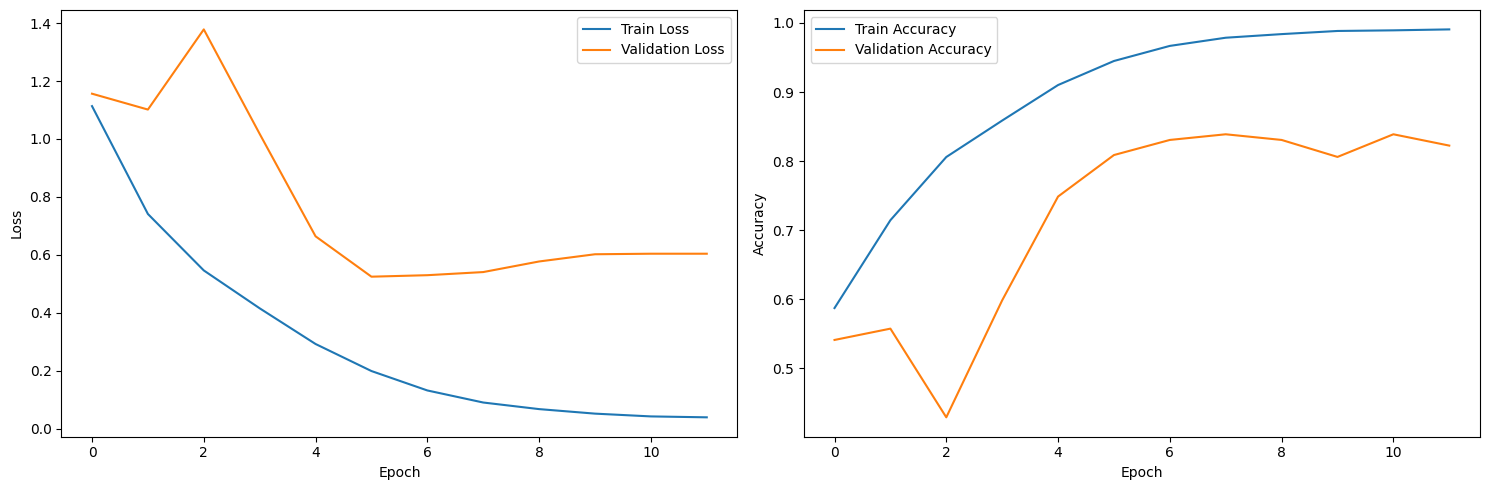

In [ ]:
ig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history.history['loss'],label='Train Loss')
axes[0].plot(history.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'],label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

Sample image shape: (512, 512, 3)
Sample image processed shape for model input: (1, 512, 512, 3)
Sample label: [0. 0. 0. 0. 1.]


In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Raw attention map shape: (14, 14)
Resized attention map shape: (512, 512)
Model prediction for sample image: [[0.0059366  0.07687273 0.731426   0.01903035 0.16673428]]


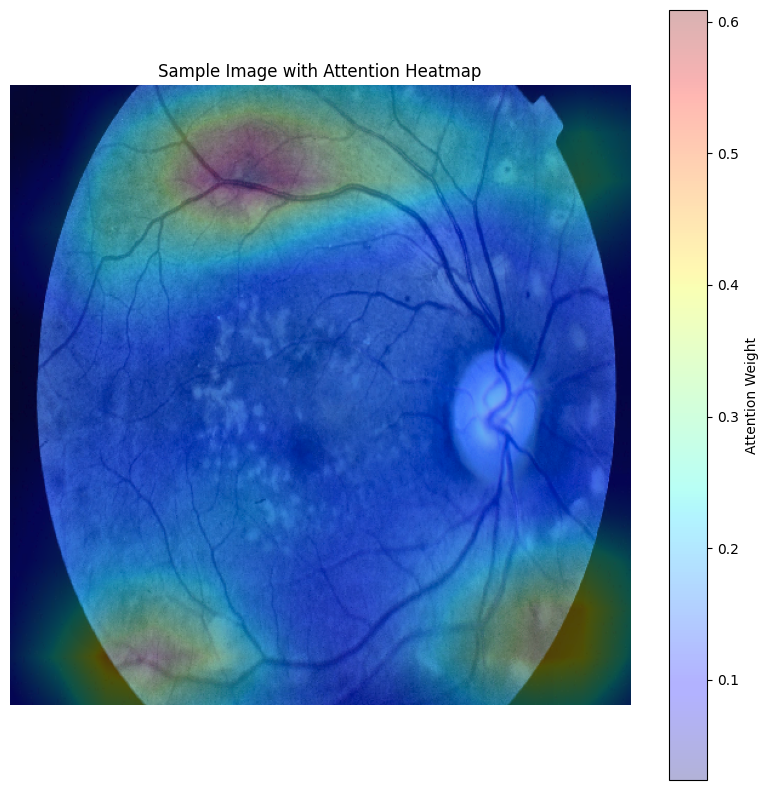

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.3)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

## Report

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

def evaluate_and_plot_confusion_matrix(model, df, image_directory, image_resize_func):
    true_labels = []
    predicted_labels = []


    unique_diagnoses = sorted(df['diagnosis'].unique().tolist())
    class_name_to_int = {str(val): idx for idx, val in enumerate(unique_diagnoses)}

    print(f"Evaluating {len(df)} images...")

    for index, row in df.iterrows():
        img_id = row['id_code']
        true_diagnosis_str = row['diagnosis']


        if 'full_path' in df.columns:
            full_path = row['full_path']
        else:
            full_path = os.path.join(image_directory, f"{img_id}.png")


        img = cv2.imread(full_path)
        if img is None:
            print(f"Warning: Could not load image {full_path}. Skipping.")
            continue


        processed_img = image_resize_func(img)
        processed_img = np.expand_dims(processed_img, axis=0)


        prediction = model.predict(processed_img, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]

        true_labels.append(class_name_to_int[true_diagnosis_str])
        predicted_labels.append(predicted_class)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)


    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=[str(i) for i in sorted(class_name_to_int.values())]))


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(true_labels, predicted_labels),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(i) for i in sorted(class_name_to_int.values())],
                yticklabels=[str(i) for i in sorted(class_name_to_int.values())])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Evaluating 366 images...

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.79       199
           1       0.17      0.10      0.12        30
           2       0.53      0.21      0.30        87
           3       0.00      0.00      0.00        17
           4       0.45      0.15      0.23        33

    accuracy                           0.61       366
   macro avg       0.36      0.29      0.29       366
weighted avg       0.54      0.61      0.53       366



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


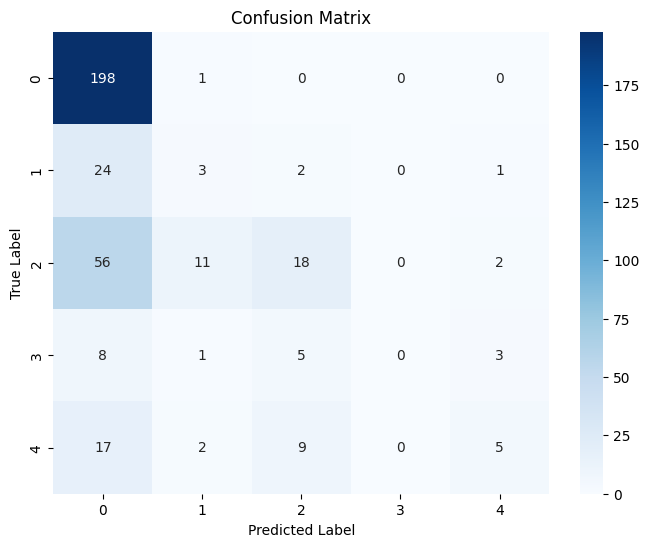

In [ ]:
evaluate_and_plot_confusion_matrix(model, val_df, test_images, image_resize)


# Let'e Use Only The DR Images




In [7]:
y_true=y_true[y_true['diagnosis']!='0']

In [8]:
y_true['diagnosis'].value_counts()

,count
diagnosis,
2,808
1,300
4,234
3,154


## Make Our New Only DR Dataset

In [42]:
def create_augmentation_layer():
    """Augmentation for balancing: flips, rotation, crop, zoom"""
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.08, fill_mode="constant"),  # ~15 degrees
            tf.keras.layers.RandomZoom(0.1),
        ]
    )

In [43]:
IM_SIZE=700

In [44]:
def augment_and_save_balanced_dataset(
    df, img_dir, output_dir, target_percentages=None, target_size=(IM_SIZE, IM_SIZE)
):
    """
    Augment classes based on percentage multipliers and save to disk

    Args:
        df: DataFrame with 'id_code' and 'diagnosis' columns
        img_dir: Source images directory
        output_dir: Where to save augmented dataset
        target_percentages: dict {class_id: multiplier} e.g. {0: 1.0, 1: 2.0, 3: 3.0}
                           1.0 = keep current, 2.0 = double, etc.
        target_size: Image resize dimensions

    Returns:
        new_df: DataFrame with all images (original + augmented)
    """
    from collections import Counter

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    class_counts = Counter(df["diagnosis"].values)
    print("Original distribution:", dict(class_counts))

    augmentation = create_augmentation_layer()
    new_data = []

    for class_id in sorted(class_counts.keys()):
        class_df = df[df["diagnosis"] == class_id]
        current_count = len(class_df)

        # Calculate target based on percentage
        multiplier = target_percentages.get(int(class_id), 1.0) if target_percentages else 1.0
        target_count = int(current_count * multiplier)
        needed = max(0, target_count - current_count)

        # Add all original images to metadata
        for _, row in class_df.iterrows():
            new_data.append({
                "id_code": row["id_code"], # row['id_code'] is without .png here
                "diagnosis": class_id,
                "is_augmented": False
            })

        # Generate augmented images
        if needed > 0:
            print(f"Class {class_id}: Augmenting {current_count} → {target_count} ({multiplier}x, +{needed} images)")

            for i in range(needed):
                # Sample random image from class
                row = class_df.sample(1).iloc[0]

                # Load with TF, adding .png extension
                img_path = os.path.join(img_dir, f"{row['id_code']}.png")
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, target_size)
                #img = img / 255.0
                img = tf.expand_dims(img, 0)

                # Apply augmentation
                aug_img = augmentation(img, training=True)[0]

                # Save augmented image, new_id is created without .png extension
                new_id = f"{row['id_code']}_aug_{i}"
                save_path = str(output_dir / f"{new_id}.png") # Save with .png extension
                tf.keras.utils.save_img(save_path, aug_img)

                new_data.append({
                    "id_code": new_id, # Store without .png
                    "diagnosis": class_id,
                    "is_augmented": True
                })
        else:
            print(f"Class {class_id}: No augmentation needed (multiplier={multiplier}x)")

    # Save new CSV
    new_df = pd.DataFrame(new_data)
    new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)
    new_df.to_csv(output_dir / "labels.csv", index=False)

    print(f"\nTotal dataset: {len(new_df)} images")
    print(f"Augmented: {new_df['is_augmented'].sum()} images")
    print("Final distribution:", dict(Counter(new_df["diagnosis"].values)))

    return new_df

# Usage
target_percentages = {
    #0: 1.0,   # No DR - keep as is
    1: 2.0,   # Mild - double
    2: 1.0,   # Moderate - keep as is
    3: 4.0,   # Severe - triple
    4: 4.0,   # Proliferative - 2.5x
}

balanced_df = augment_and_save_balanced_dataset(
    y_true,
   unbalanced_data_path,
    "percent_train",
    target_percentages=target_percentages
)

Original distribution: {'2': 808, '1': 300, '4': 234, '3': 154}
Class 1: Augmenting 300 → 600 (2.0x, +300 images)
Class 2: No augmentation needed (multiplier=1.0x)
Class 3: Augmenting 154 → 616 (4.0x, +462 images)
Class 4: Augmenting 234 → 936 (4.0x, +702 images)

Total dataset: 2960 images
Augmented: 1464 images
Final distribution: {'3': 616, '2': 808, '4': 936, '1': 600}


In [45]:
def get_combined_paths(balanced_df, original_dir, augmented_dir):
    paths = []
    labels = []

    # Get absolute path for the augmented directory
    abs_augmented_dir = Path(augmented_dir).resolve()

    for _, row in balanced_df.iterrows():
        # balanced_df['id_code'] contains filenames WITHOUT .png extension
        if row['is_augmented']:
            # Augmented files were saved as {id_code}_aug_X.png
            path = abs_augmented_dir / f"{row['id_code']}.png"
        else:
            # Original files are {id_code}.png
            path = Path(original_dir) / f"{row['id_code']}.png"
        paths.append(str(path)) # Ensure it's a string
        labels.append(row['diagnosis'])

    return paths, labels

# Load balanced dataset

# balanced_df = pd.read_csv(f"{balanced_output_dir}/labels.csv")
# paths, labels = get_combined_paths(balanced_df, train_dir, f"{balanced_output_dir}")

percentage_train_set= "percent_train"
balanced_df = pd.read_csv(f"{percentage_train_set}/labels.csv")
paths, labels = get_combined_paths(balanced_df, unbalanced_data_path, f"{percentage_train_set}")

In [46]:
balanced_df

,id_code,diagnosis,is_augmented
0,4d9fc85a8259_aug_450,3,True
1,6baafa56895c_aug_126,3,True
2,4242c0d87f57,2,False
3,37c4dfe03aba,4,False
4,1bf30c84bbad,4,False
...,...,...,...
2955,5b3e7197ac1c_aug_76,3,True
2956,98e8adcf085c,2,False
2957,a01c590c444f,2,False
2958,c80f79579fed,2,False


In [47]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(IM_SIZE,IM_SIZE))
  image=image/255.0
  return image

In [48]:
val_df=pd.read_csv(path+'/test.csv')
val_df['diagnosis']=val_df['diagnosis'].astype(str)
val_df=val_df[val_df['diagnosis']!='0']
val_df['id_code']=val_df['id_code'].str.replace('.png', '', regex=False) # Ensure id_code does NOT end with .png
test_images=path+'/test_images/test_images/' # Corrected path for nested test images

In [49]:
balanced_df['id_code']=balanced_df['id_code'].str.replace('.png', '', regex=False)

In [50]:
balanced_df['paths']=paths

In [51]:
balanced_df.head()

,id_code,diagnosis,is_augmented,paths
0,4d9fc85a8259_aug_450,3,True,/content/percent_train/4d9fc85a8259_aug_450.png
1,6baafa56895c_aug_126,3,True,/content/percent_train/6baafa56895c_aug_126.png
2,4242c0d87f57,2,False,/kaggle/input/aptos2019/train_images/train_ima...
3,37c4dfe03aba,4,False,/kaggle/input/aptos2019/train_images/train_ima...
4,1bf30c84bbad,4,False,/kaggle/input/aptos2019/train_images/train_ima...


In [53]:
balanced_df['diagnosis']=balanced_df['diagnosis'].astype(str)

In [62]:
train_datagen = ImageDataGenerator(preprocessing_function=image_resize)

val_gen=ImageDataGenerator(preprocessing_function=image_resize)


train_gen = train_datagen.flow_from_dataframe(balanced_df,
                                                    x_col='paths',
                                                    y_col='diagnosis',
                                                    directory = None,
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=8,
                                                    class_mode='categorical')


val_df['full_path'] = val_df['id_code'].apply(lambda x: os.path.join(test_images, f"{x}.png"))
val_df['diagnosis'] = val_df['diagnosis'].astype(str)

val_gen = train_datagen.flow_from_dataframe(val_df,
                                                  x_col='full_path',
                                                  y_col='diagnosis',
                                                  directory = None,
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=8,
                                                  class_mode='categorical')

Found 2960 validated image filenames belonging to 4 classes.
Found 167 validated image filenames belonging to 4 classes.


## Load The InceptionV3


In [63]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
print("Pre-trained InceptionV3 model loaded successfully.")

Pre-trained InceptionV3 model loaded successfully.


In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

In [65]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)

In [66]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='inV3best_with_weights.keras',monitor='accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,restore_best_weights=True,mode='max')

In [67]:
def lr_schedule_exp(epoch):
  if epoch<4:
    return float(tf.exp(-epoch/10.)*0.01)/3
  elif epoch<8:
    return float(tf.exp(-epoch/10.)*0.01)/4
  else:
    return float(tf.exp(-epoch/10.)*0.01)/5

schedule_4=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)

In [68]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [69]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,callbacks=[model_checkpoint_callback,early_stop_it])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - accuracy: 0.4359 - loss: 1.2523 - val_accuracy: 0.5629 - val_loss: 1.1131
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.6382 - loss: 0.8797 - val_accuracy: 0.6407 - val_loss: 0.8754
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.7350 - loss: 0.6751 - val_accuracy: 0.6467 - val_loss: 0.9015
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.8065 - loss: 0.5340 - val_accuracy: 0.6946 - val_loss: 0.8742
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.8869 - loss: 0.3692 - val_accuracy: 0.6587 - val_loss: 0.9560
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.8927 - loss: 0.3017 - val_accuracy: 0.6228 - val_loss: 0.9369
Epoch 7/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.9436 - loss: 0.2137 - val_accuracy: 0.6527 - val_loss: 1.1027
Epoch 8/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.9564 - loss: 0.1635 - val_accu